### Read in data

In [6]:
library(edgeR)
# install.packages("reshape2")
#install.packages("tidyr")
library(reshape2)
#library(tidyverse)

#library(rstatix)
library(tidyr)
library(dplyr)
#library(ggpubr)
library(ggplot2)
library(EnhancedVolcano)
library(countdata)
library(stringr)

Loading required package: limma


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggrepel



In [30]:
raw_counts = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_all.tsv"
info = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_with_info.tsv"

# read in tabel with raw counts
raw_counts = read.table(raw_counts, header = TRUE, sep = "\t")
# read in table with info
info = read.table(info, header = TRUE, sep = "\t")
# merge the two tables on the column "Synt_id"
raw_counts = merge(raw_counts, info, by = "Synt_id")
# set synt_id as rownames
rownames(raw_counts) = raw_counts$Synt_id
# remove the column "Synt_id"
raw_counts = raw_counts[,-1]
# replaace NA values with 0
raw_counts[is.na(raw_counts)] = 0
# filter the genes that have length_category == more_20%_difference and mulitmapping_tag = mulitmapping 
#raw_counts_filter = raw_counts[raw_counts$multi_ratio <= 0.05,]
raw_counts_filter = raw_counts[raw_counts$length_category != "more_20%_difference" & raw_counts$multi_ratio <= 0.10,]
# get the sample columns starting with SRR
sample_columns = colnames(raw_counts_filter)[grep("SRR", colnames(raw_counts_filter))]
# only keeep the columns with the sample names
raw_counts_filter = raw_counts_filter[, sample_columns]
raw_counts = raw_counts[, sample_columns]

# filter for synts that have at least 10 counts for each allele 
allele_1 = colnames(raw_counts_filter)[grep("_1", colnames(raw_counts_filter))]
allele_2 = colnames(raw_counts_filter)[grep("_2", colnames(raw_counts_filter))]
allele_3 = colnames(raw_counts_filter)[grep("_3", colnames(raw_counts_filter))]
allele_4 = colnames(raw_counts_filter)[grep("_4", colnames(raw_counts_filter))]

# filter for synts that have at least 10 counts for each allele 
#raw_counts_filter = raw_counts_filter[rowSums(raw_counts_filter[,allele_1]) > 10 & rowSums(raw_counts_filter[,allele_2]) > 10 & rowSums(raw_counts_filter[,allele_3]) > 10 & rowSums(raw_counts_filter[,allele_4]) > 10,]
leaf_samples = colnames(raw_counts_filter)[grep("leaf", colnames(raw_counts_filter))]
tuber_samples = colnames(raw_counts_filter)[grep("tuber", colnames(raw_counts_filter))]
raw_counts_filter = raw_counts_filter[rowSums(raw_counts_filter[,leaf_samples]) > 200 & rowSums(raw_counts_filter[,tuber_samples]) > 200,]

# filter for synts that have at least 50 counts 

dim(raw_counts_filter)
dim(info)

[1] 435  40

[1] 9298   19

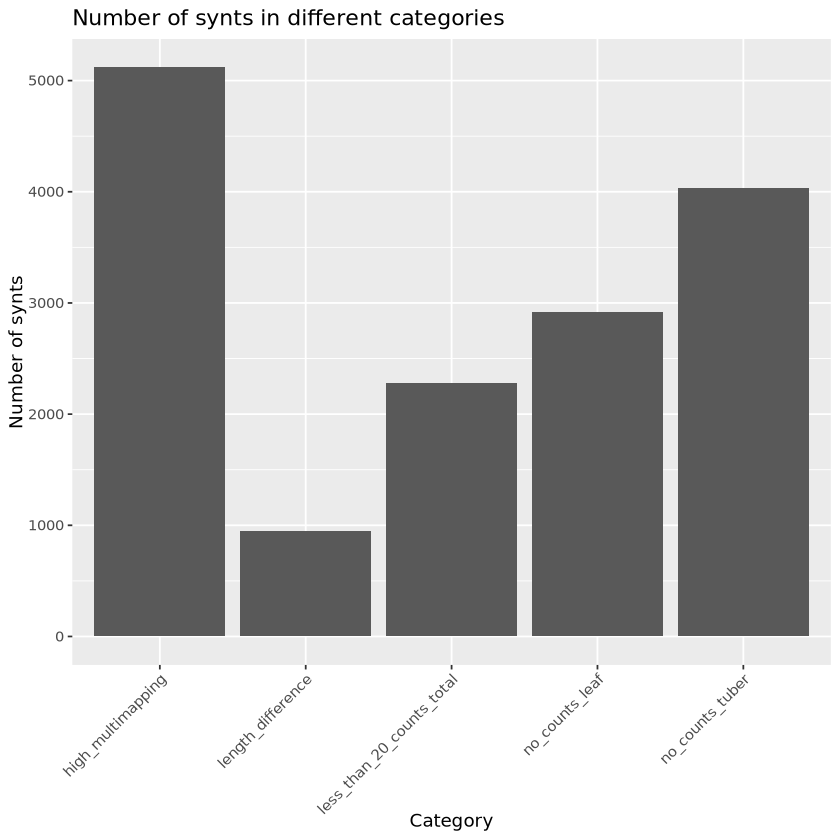

In [53]:
# get the number of synts that have less than 10 counts for all alleles
less_than_20_counts_total = sum(rowSums(raw_counts) < 20)
no_counts_tuber = sum(rowSums(raw_counts[,tuber_samples]) < 20)
no_counts_leaf = sum(rowSums(raw_counts[,leaf_samples]) < 20)
high_multimapping = sum(info$multi_ratio > 0.25)#
length_difference = sum(info$length_category == "more_20%_difference")


# make a barplot for the different categories
data = data.frame(category = c("less_than_20_counts_total", "no_counts_tuber", "no_counts_leaf", "high_multimapping", "length_difference"),
                   count = c(less_than_20_counts_total, no_counts_tuber, no_counts_leaf, high_multimapping, length_difference))


ggplot(data, aes(x = category, y = count)) +
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Number of synts in different categories", x = "Category", y = "Number of synts")

In [ ]:
# get the synt ids that are only expressed in tuber
synt_ids_tuber_only = rownames(raw_counts[rowSums(raw_counts[,tuber_samples]) > 100 & rowSums(raw_counts[,leaf_samples]) == 0,])
length(synt_ids_tuber_only)

[1] 4

[1] 435  19

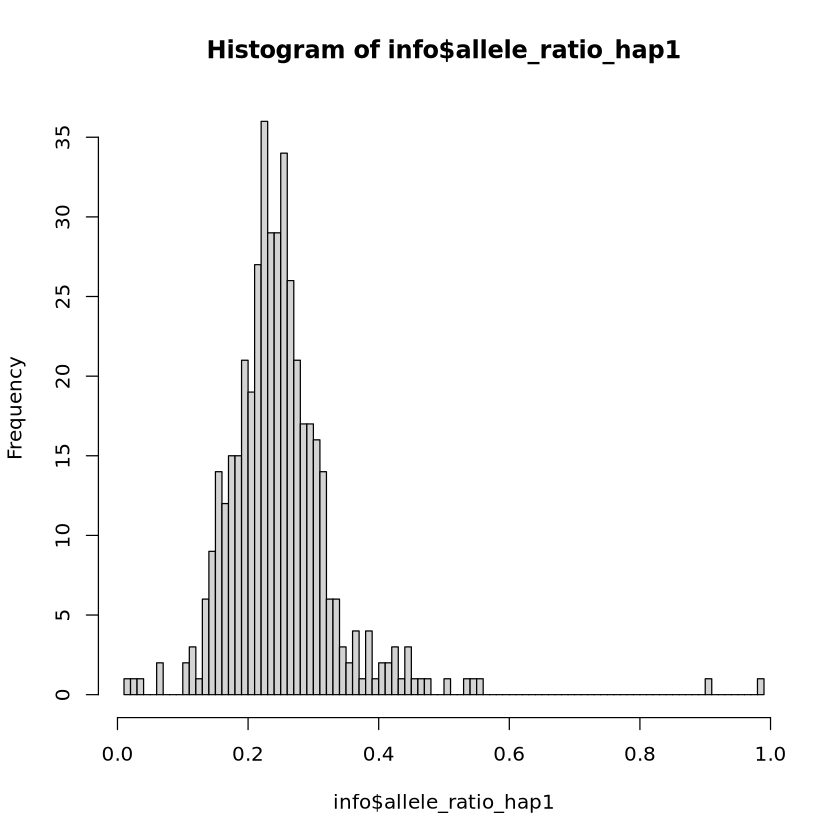

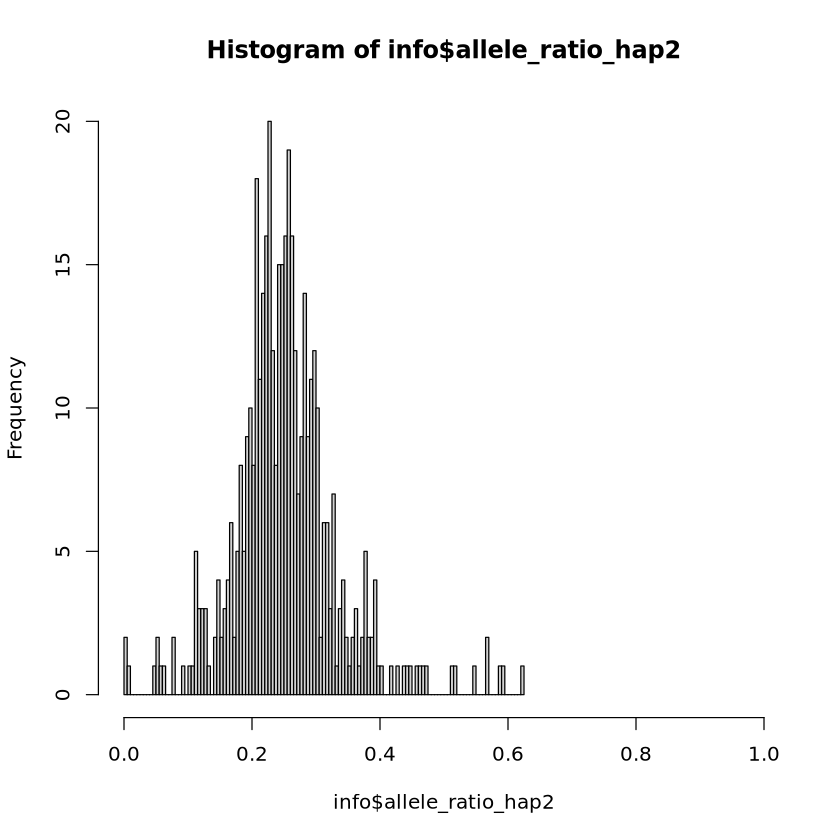

In [7]:
# filter the info to only keep the synts that are in the raw_counts_filter
info = info[info$Synt_id %in% rownames(raw_counts_filter),]
dim(info)

hist(info$allele_ratio_hap1, breaks = 100)

hist(info$allele_ratio_hap2, breaks = 100,xlim = c(0,1))

### T-test


### Beta-Bionomial test

Sum the count within each sample

In [8]:
# Define the list of allele suffixes
allele_suffixes <- c("_1", "_2", "_3", "_4")

# Create a copy of raw_counts_filter for modifications
raw_counts_filter_bionom <- raw_counts_filter

raw_counts_filter_bionom$Synt_ids <- rownames(raw_counts_filter_bionom)
# Assume `raw_counts_filter_bionom` has the processed data with columns: Synt_id, base_variable, allele counts
# Convert the data to long format
melted_table <- raw_counts_filter_bionom %>%
  pivot_longer(
    cols = starts_with("SRR"), # Adjust column name pattern if needed
    names_to = "variable",
    values_to = "value"
  )

# Extract allele information (_1, _2, _3, _4) from the variable names
melted_table <- melted_table %>%
  mutate(
    allele = case_when(
      str_detect(variable, "_1$") ~ "allele_1",
      str_detect(variable, "_2$") ~ "allele_2",
      str_detect(variable, "_3$") ~ "allele_3",
      str_detect(variable, "_4$") ~ "allele_4",
      TRUE ~ NA_character_
    )
  )

# Remove rows where allele is NA (if any)
melted_table <- melted_table %>%
  filter(!is.na(allele))

# Replace `_1`, `_2`, `_3`, `_4` suffixes in the 'variable' column to create 'base_variable'
melted_table <- melted_table %>%
  mutate(base_variable = str_remove(variable, "_[1234]$"))

melted_table$tissue = str_split_fixed(melted_table$base_variable, "_", 3)[,2]
#melted_table

# Pivot the table to have alleles as columns and genes + samples as rows
pivoted_table <- melted_table %>%
  pivot_wider(
    id_cols = c(Synt_ids, base_variable), # Rows: gene (Synt_id) and sample (base_variable)
    names_from = allele,                # Columns: alleles
    values_from = value                 # Values: counts
  )


# add a column with the sum of the counts for each gene
pivoted_table$sum_counts = rowSums(pivoted_table[,grep("allele", colnames(pivoted_table))])



# group by base_varialbe and Synt_id and sum the values and add the sum to the table
melted_table = melted_table %>% group_by(base_variable, Synt_ids) %>% mutate(sum_counts = sum(value))

In [9]:
# select only allels 1 and 2
melted_table = melted_table[melted_table$allele %in% c("allele_1", "allele_2"),]
# test data for synt 261
#melted_table = melted_table[melted_table$Synt_ids == "261",]

# Split the data by unique Synt_id values
split_data <- split(melted_table, melted_table$Synt_ids)

# Use lapply to perform the operation on each subset and collect results
results_list <- lapply(names(split_data), function(synt_id) {
  test_data <- split_data[[synt_id]]
  
  # Drop the rows where sum_allele is 0
  test_data <- test_data[test_data$sum_counts != 0, ]
  # Drop the rows where allele_1 is 0
  #test_data <- test_data[test_data$allele_1 != 0, ]
  # Check if there's enough data to perform the test
  if (nrow(test_data) < 2) {
    return(data.frame(
      Synt_id = synt_id,
      p_value = NA,
      mean_group1 = NA,
      mean_group2 = NA,
      log_fold_change = NA
    ))
  }
  
  # Perform the Binomial test
  test_result <- bb.test(
    x = test_data$value,
    tx = test_data$sum_counts,
    group = test_data$allele,
    n.threads = 10
  )
  
  # Calculate the means for the two groups
  group_means <- aggregate(
    cbind(value, sum_counts) ~ allele,
    data = test_data,
    FUN = sum
  )
  group_means$mean <- group_means$value/ group_means$sum_counts
  # Ensure there are exactly two groups
  if (nrow(group_means) != 2) {
    return(data.frame(
      Synt_id = synt_id,
      p_value = NA,
      mean_group1 = NA,
      mean_group2 = NA,
      log_fold_change = NA
    ))
  }
  
  # Calculate log fold change
  fold_change <- (group_means$mean[1] / group_means$mean[2])
  
  # Create a data frame with the results
  data.frame(
    Synt_id = synt_id,
    p_value = test_result$p.value,
    mean_group1 = group_means$mean[1],
    mean_group2 = group_means$mean[2],
    fold_change = fold_change
  )
})

# Combine the list of data frames into a single data frame
results_df <- do.call(rbind, results_list)

Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 20.
1

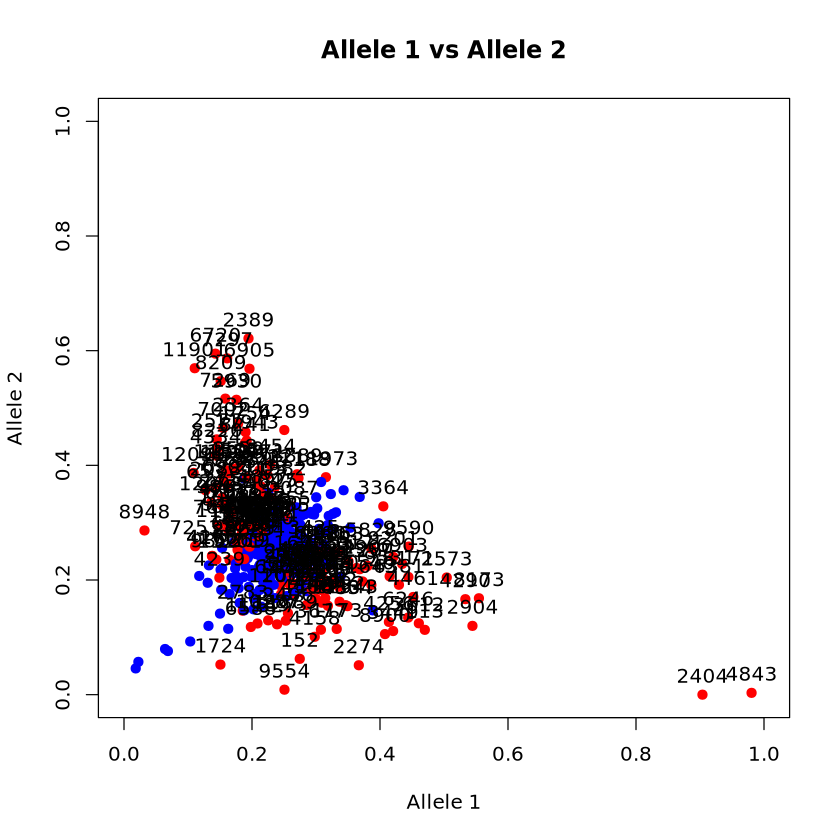

In [ ]:
results_df$p_adj = p.adjust(results_df$p_value, method = "fdr")
# add a column for significant genes werhe p_adj < 0.005
results_df$significant = ifelse(results_df$p_adj < 0.005 & abs(results_df$mean_group1 - results_df$mean_group2) > 0.2), "red", "blue")
plot(results_df$mean_group1, results_df$mean_group2, xlab = "Allele 1", ylab = "Allele 2", main = "Allele 1 vs Allele 2",  col = results_df$significant, pch = 19, ylim = c(0,1), xlim = c(0,1))
# label the points that are red
text(results_df$mean_group1[results_df$significant == "red"], results_df$mean_group2[results_df$significant == "red"], labels = results_df$Synt_id[results_df$significant == "red"], pos = 3)

In [56]:
# count the number of significant genes
# filter the results_df for significant genes
results_df_significant = results_df[results_df$p_adj < 0.05,]
# group the results by synt id
results_df_significant_grouped = results_df_significant %>% group_by(Synt_id) %>% summarise(n = n())
nrow(results_df_significant_grouped)
dim( results_df)

[1] 153

[1] 232   7

In [54]:
# print counts for Synt_id 4314
info[info$Synt_id == "4843",]
melted_table[melted_table$Synt_ids == "4843",]

,Synt_id,X1,X2,X3,X4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
3837,4843,2169,7,29,7,4,0.001805054,0.9805606,0.003164557,0.01311031,0.003164557,unique,1148,1148,1163,1151,Synt_9760_chr04_1G_x8|hap1_Soltu.DM.04G004550.1|Soltu.Atl_v3.04_1G004740Synt_9760_chr04_2G_x8|hap2_Soltu.DM.04G004550.1|Soltu.Atl_v3.04_2G003560Synt_9760_chr04_3G_x8|hap3_Soltu.DM.04G004550.1|Soltu.Atl_v3.04_3G003830Synt_9760_chr04_4G_x8|hap4_Soltu.DM.04G004550.1|Soltu.Atl_v3.04_4G003730,more_1%_difference,3G


Synt_ids,variable,value,allele,base_variable,tissue,sum_counts
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
4843,SRR14993892_leaf_1,93,allele_1,SRR14993892_leaf,leaf,96
4843,SRR14993892_leaf_2,1,allele_2,SRR14993892_leaf,leaf,96
4843,SRR14993893_leaf_1,57,allele_1,SRR14993893_leaf,leaf,58
4843,SRR14993893_leaf_2,0,allele_2,SRR14993893_leaf,leaf,58
4843,SRR14993894_leaf_1,368,allele_1,SRR14993894_leaf,leaf,380
4843,SRR14993894_leaf_2,2,allele_2,SRR14993894_leaf,leaf,380
4843,SRR14993895_leaf_1,290,allele_1,SRR14993895_leaf,leaf,295
4843,SRR14993895_leaf_2,1,allele_2,SRR14993895_leaf,leaf,295
4843,SRR14995031_tuber_1,435,allele_1,SRR14995031_tuber,tuber,445


In [63]:
info[info$Synt_id == "7013",]
melted_table[melted_table$Synt_ids == "7013",]

,Synt_id,X1,X2,X3,X4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
5597,7013,127,51,241,33,5,0.01094092,0.2809735,0.1128319,0.5331858,0.07300885,unique,2045,2019,2065,2018,Synt_14421_chr06_1G_x4|hap1_Soltu.DM.06G000670.1|Soltu.Atl_v3.06_1G000550Synt_14421_chr06_2G_x4|hap2_Soltu.DM.06G000670.1|Soltu.Atl_v3.06_2G000720Synt_14421_chr06_3G_x4|hap3_Soltu.DM.06G000670.1|Soltu.Atl_v3.06_3G000710Synt_14421_chr06_4G_x4|hap4_Soltu.DM.06G000670.1|Soltu.Atl_v3.06_4G000710,more_1%_difference,3G


Synt_ids,variable,value,allele,base_variable,tissue,sum_counts
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>


In [28]:
info[info$Synt_id == "11552",]
melted_table[melted_table$Synt_ids == "11552",]

,Synt_id,X1,X2,X3,X4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
7174,11552,25,2832,1799,1144,274,0.04511031,0.004310345,0.4882759,0.3101724,0.1972414,unique,3196,1578,3190,1591,Synt_28752_chr12_1G_x3|hap1_Soltu.DM.12G008650.1|Soltu.Atl_v3.12_1G002600Synt_28752_chr12_2G_x3|hap2_Soltu.DM.12G008650.1|Soltu.Atl_v3.12_2G009380no_syntelog_chr12_3G_x|hap3_Soltu.DM.12G008650.1|Soltu.Atl_v3.12_3G007320Synt_28752_chr12_4G_x3|hap4_Soltu.DM.12G008650.1|Soltu.Atl_v3.12_4G004960,more_20%_difference,1G


Synt_ids,variable,value,allele,base_variable,tissue,sum_counts
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
11552,SRR14993892_leaf_1,2,allele_1,SRR14993892_leaf,leaf,298
11552,SRR14993892_leaf_2,135,allele_2,SRR14993892_leaf,leaf,298
11552,SRR14993893_leaf_1,1,allele_1,SRR14993893_leaf,leaf,156
11552,SRR14993893_leaf_2,62,allele_2,SRR14993893_leaf,leaf,156
11552,SRR14993894_leaf_1,6,allele_1,SRR14993894_leaf,leaf,1327
11552,SRR14993894_leaf_2,648,allele_2,SRR14993894_leaf,leaf,1327
11552,SRR14993895_leaf_1,5,allele_1,SRR14993895_leaf,leaf,749
11552,SRR14993895_leaf_2,364,allele_2,SRR14993895_leaf,leaf,749
11552,SRR14995031_tuber_1,1,allele_1,SRR14995031_tuber,tuber,556


In [9]:
melted_table

Synt_ids,variable,value,allele,base_variable,tissue,sum_counts
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
53,SRR14993892_leaf_1,3,allele_1,SRR14993892_leaf,leaf,27
53,SRR14993892_leaf_2,6,allele_2,SRR14993892_leaf,leaf,27
53,SRR14993893_leaf_1,5,allele_1,SRR14993893_leaf,leaf,15
53,SRR14993893_leaf_2,1,allele_2,SRR14993893_leaf,leaf,15
53,SRR14993894_leaf_1,33,allele_1,SRR14993894_leaf,leaf,162
53,SRR14993894_leaf_2,23,allele_2,SRR14993894_leaf,leaf,162
53,SRR14993895_leaf_1,24,allele_1,SRR14993895_leaf,leaf,73
53,SRR14993895_leaf_2,12,allele_2,SRR14993895_leaf,leaf,73
53,SRR14995031_tuber_1,5,allele_1,SRR14995031_tuber,tuber,44


#### Test

## Testing